# Background and foreground estimation via PCA
## Sokolov Igor

## Description:
The goal of the project is to implpement experimental results from the following papers:

### 1. "A Nonconvex Projection Method for Robust PCA" 
(Aritra Dutta, Filip Hanzely, Peter Richtarik)
##### Later we will call it "rpca-alt"(Alternating projection method for RPCA) - The Algorithm 2 on the page 5 of the paper

### 2. "Robust PCA using Matrix Factorization for Background/Foreground Separation" 
(Shuqin Wang, Yongli Wang, Yongyong Chen, Peng Pan, Zhipeng Sun, and Guoping He)
##### Later we will call it "rpca-ALF" (RPCA with Augmented Lagrangian Function)

In [1]:
format compact
format short

### Download data and select test frame

In [ ]:
data = load("Stuttgart_144_176.mat");
A = data.I;
number_test_frame = 110;
image_height = 144; 
image_width = 176;

Some comments on the names of the variables used below

* A - dataset (matrix )    
                                               
* S_alt_2, S_alt_5, L_alt_2 ,L_alt_5 -- matrices L and S obtained by, method rpca_alt where "..._ 2" and "..._ 5"  are the considered ranks for L (I considered two cases)

* Rel_error_alt_2, Rel_error_alt_5 -- relative error for rpca_alt method

* L_alf_laplace_2, L_alf_laplace_5, S_alf_laplace_2, S_alf_laplace_5 -- matrices L and S obtained by rpca_ALF with a surrogate function of the Laplace type, where _2 _5 are the considered ranks for L (considered two cases r = 2 and r = 5)

* Rel_laplace_error_alf_2, Rel_laplace_error_alf_5 -- относительная ошибка для метода rpca_ALF

# 1 "A Nonconvex Projection Method for Robust PCA" 
## experiment on page 10


Projection operator

In [43]:
%%file Tproj.m
function S = Tproj(S, a_col, a_row)
% The T() operator for sparse prejection

%%%%%%%%%%%
% A Nonconvex Projection method for Robust PCA, Aritra Dutta, Filip
% Hanzely, and Peter Richt�rik, Thirty-Third AAAI Conference on Artificial
% Intelligence, 2019. 
%%%%%%%%%%%

[d1, d2] = size(S);
kcol = d1-floor(a_col*d1);
krow = d2-floor(a_row*d2);


Scol=nth_element(abs(S),kcol);
Srow=nth_element(abs(S'),krow);

S((abs(S)<=Scol(kcol,:))|((abs(S)'<=Srow(krow,:))'))=0;
S=sparse(S);
end


Created file '/Users/igorsokolov/Google_Drive/GMML_project/comparison/Tproj.m'.


In [47]:
%%file rpca_alt.m

function [L, S, Rel_error, Time] = rpca_alt(A, r, alpha, params)

%%%%%%%%%%%
% A Nonconvex Projection method for Robust PCA, Aritra Dutta, Filip
% Hanzely, and Peter Richt�rik, Thirty-Third AAAI Conference on Artificial
% Intelligence, 2019. 
%%%%%%%%%%%

% A : A data matrix to be decomposed into a low-rank matrix L and a sparse
% matrix M. Unobserved entries are represented as zeros.
% r : Target rank
% alpha : An upper bound of max sparsity over the columns/rows of S
% params : parameters for the algorithm
%   .max_iter : Maximum number of iterations (default 30)
%   .tol : Desired Frobenius norm error (default 2e-4)
%%%%%%%%%%%
% Output:: L : Low rank matrix of rank r
%          S : Sparse matrix of sparsity alpha*m*n
%  Rel_error : ||A-L-S||_F/||A||_F
%  Time
tic
% Default parameter settings

%%%% Read paramter settings
if isfield(params,'gamma')
    gamma = params.gamma;
end
if isfield(params,'max_iter')
    maxIter = params.max_iter;
end
if isfield(params,'thresh')
    thresh= params.thresh;
end

% Add Library paths
addpath PROPACK;
addpath bksvd-master;

%%%%%% Setting up %%%%%%%

Norm_of_A = norm(A,'fro');
[d1, d2] = size(A);

is_sparse  = issparse(A);
if is_sparse
    [I, J, A_vec] = find(A);
    n = length(A_vec);
    obs_ind = sub2ind([d1,d2], I, J);
    col = [0; find(diff(J)); n];
    p = n/d1/d2;
    if p>0.9
        is_sparse = 0;
        A = full(A);
    end
else
    p = 1;
end

%%%%% Initialization %%%%%%%
L_old = zeros(size(A));
S_old = zeros(size(A));
Rel_error = zeros(1, maxIter); converged = 0; %%(When showing converegcne of the algorithm)
Time = zeros(1, maxIter);
iter = 0;

%%%% Iteration %%%%%%%%%
%for i = 1:maxIter
while ~converged
    iter  = iter+1;

    %%% Projection on the convex set::: A=L+S
    L_temp = L_old/2-S_old/2+A/2;
    S_temp = S_old/2-L_old/2+A/2;

    %%%% Low rank Projection%%%%%%

    if p==1
        [U,Sigma,V] = bksvd(L_temp,r,1);
    else
        [U, Sigma, V] = lansvd(L_temp,r,'L');
    end

    L = U*Sigma*V';

    %%%% Sparse Projection %%%%%%

    S = Tproj(S_temp, gamma*p*alpha, gamma*p*alpha);

    Residual = A-L-S;
    Rel_error(1, iter) = norm(Residual,'fro')/Norm_of_A;
    Time (1, iter) = toc;
    L_old = L;
    S_old = S;

    %%%%  Convergence criteria %%%%
    if (Rel_error(iter) <= thresh ||iter>maxIter)
         converged = 1;
    end
    
end
toc


Created file '/Users/igorsokolov/Google_Drive/GMML_project/comparison/rpca_alt.m'.


In [48]:
params.max_iter   = 100;
params.thresh    = 2e-4;
params.gamma     = 1;

r = 5; 
alpha = 0.1;
[L_alt_5, S_alt_5, Rel_error_alt_5, Time_alt_5] = rpca_alt(A, r, alpha, params);

r = 2; 
[L_alt_2, S_alt_2, Rel_error_alt_2] = rpca_alt(A, r, alpha, params);

> In path (line 109)
  In addpath (line 86)
  In rpca_alt (line 33)
Elapsed time is 94.652956 seconds.
> In path (line 109)
  In addpath (line 86)
  In rpca_alt (line 33)
Elapsed time is 93.948649 seconds.


# 2 "Robust PCA using Matrix Factorization for Background/Foreground Separation" 


### Later we will cal it "rpca-ALF"

In [33]:
%%file get_l.m

function l = get_l(sur_kind, sigma_v, gamma)
    assert (isvector(sigma_v));
    if strcmp (sur_kind, "laplace")
        l = exp(-sigma_v./gamma) ./gamma;
    elseif strcmp (sur_kind, "geman")
        l = (1 + gamma)*exp(sigma_v) ./(gamma + exp(sigma_v)).^2;
    else
        error("wrong surrogate function");
    end 
end


Created file '/Users/igorsokolov/Google_Drive/GMML_project/comparison/get_l.m'.


In [32]:
%%file rpca_alf.m

%thresh - eps
function [L, S, Rel_error, Time] = rpca_alf(D, r, params)
tic
Norm_of_D = norm(D,'fro');

[d1, d2] = size(D);

%%%% Read paramter settings
if isfield(params,'lambda')
    lambda = params.lambda;
end
if isfield(params,'beta')
    beta = params.beta;
end
if isfield(params,'gamma')
    gamma = params.gamma;
end
if isfield(params,'max_iter')
    maxIter = params.max_iter;
end
if isfield(params,'thresh')
    thresh= params.thresh;
end
if isfield(params,'rho_0')
    rho_old= params.rho_0;
end
if isfield(params,'rho_max')
    rho_max= params.rho_max;
end
if isfield(params,'sur_kind')
    sur_kind= params.sur_kind;
end

% Add Library paths
addpath PROPACK;

%%%%% Initialization %%%%%%%
L_old = zeros(size(D));
Lambda_old = zeros(size(D));

V_old = eye([d2, r]);
S_old = zeros(size(D));

Rel_error = zeros(1, maxIter);
Time = zeros(1, maxIter);
converged = 0; %%(When showing converegcne of the algorithm)
iter = 0;


%%%% Iteration %%%%%%%%%
%for i = 1:maxIter
while ~converged
    iter  = iter+1;
    
    T = D + Lambda_old/rho_old;
    TS_dif = T - S_old;
    
    [A, ~, B] = lansvd(TS_dif*V_old, r, 'L');
    %[A, ~, B] = svd( TS_dif*V_old );
    
    U_temp = A*B';
    
    [A_v, Sigma_v, B_v] = lansvd(V_old, r, 'L');
    d_v = diag(Sigma_v);
    
    l = get_l(sur_kind, d_v, gamma); %equation (18) in the paper
    
    %disp ([size(A_v), size(l), size(B_v)]);
    
    assert (isvector(l));
    subgrad_V = A_v*diag(l)*B_v';
    
    V_temp = TS_dif'*U_temp - lambda*subgrad_V./rho_old ;
    L_temp = U_temp*V_temp'; 
    
    W = T - L_temp; 
    S_temp = max(abs(W)-1/rho_old, 0 ).*sign (W);
    
    Residual = D - L_temp - S_temp;
    
    Lambda_temp = Lambda_old + rho_old.* Residual;
    rho_temp = min(beta*rho_old, rho_max);
     
    Rel_error(1, iter) = norm(Residual, 'fro')/Norm_of_D;
    Time (1, iter) = toc;
    %disp ([iter, Rel_error(iter), rho_temp]);
    V_old = V_temp;
    S_old = S_temp;
    L_old = L_temp;
    Lambda_old = Lambda_temp;
    rho_old = rho_temp;
    
%%%%  Convergence criteria %%%%
    if (Rel_error(iter) <= thresh ||iter>maxIter)
         converged = 1;
    end
end
    L = L_temp;
    S = S_temp;
    
toc
end

Created file '/Users/igorsokolov/Google_Drive/GMML_project/comparison/rpca_alf.m'.


In [34]:
params.lambda = 20;
params.beta = 1.5;
params.gamma = 0.05;
params.max_iter = 100;
params.thresh = 2e-4;
params.rho_0 = 0.01;

In [85]:
params.sur_kind= "laplace";
params.rho_max = 2000; %choosen impricaly
r = 5;
[L_alf_laplace_5, S_alf_laplace_5, Rel_laplace_error_alf_5] = rpca_alf(A, r, params);

Elapsed time is 6.792221 seconds.


In [86]:
params.sur_kind= "laplace";
params.rho_max = 2000; %choosen impricaly
r = 2;
[L_alf_laplace_2, S_alf_laplace_2, Rel_laplace_error_alf_2] = rpca_alf(A, r, params);

Elapsed time is 6.349430 seconds.


In [ ]:
A - датасет       
                                               
S_alt_2                                                 
S_alt_5
L_alt_2                                                       
L_alt_5                                                       
матрицы L и S полученные методом 1 rpca_alt (Alternating projection method for RPCA) algorithm 2 стр 5
где _2 _5 -- ранг L (рассматривал два случая r = 2 и r = 5)

Rel_error_alt_2                                                   
Rel_error_alt_5
-- относительная ошибка для метода rpca_alt

L_alf_laplace_2                                               
L_alf_laplace_5
S_alf_laplace_2                                               
S_alf_laplace_5

матрицы L и S полученные методом 2 rpca_ALF (RPCA with Augmented Lagrangian Function) с сурогатной функцией вида Лапласа
где _2 _5 -- ранг L (рассматривал два случая r = 2 и r = 5)

Rel_laplace_error_alf_2                                           
Rel_laplace_error_alf_5
-- относительная ошибка для метода rpca_ALF

In [87]:
[~,it_size_alt_5] = size(Rel_error_alt_5);
[~,it_size_alf_5] = size(Rel_laplace_error_alf_5);

[~,it_size_alt_2] = size(Rel_error_alt_2);
[~,it_size_alf_2] = size(Rel_laplace_error_alf_2);

image_origial = reshape(A(:,number_test_frame), image_height, image_width);

full_S_2 = full(S_alt_2);
image_L_alt_2 = reshape(L_alt_2(:,number_test_frame), image_height, image_width);
image_S_alt_2 = reshape(full_S_2(:,number_test_frame), image_height, image_width);

full_S_5 = full(S_alt_5);
image_L_alt_5 = reshape(L_alt_5(:,number_test_frame), image_height, image_width);
image_S_alt_5 = reshape(full_S_5(:,number_test_frame), image_height, image_width);

image_L_alf_laplace_2 = reshape(L_alf_laplace_2(:,number_test_frame), image_height, image_width); 
image_S_alf_laplace_2 = reshape(S_alf_laplace_2(:,number_test_frame), image_height, image_width);

image_L_alf_laplace_5 = reshape(L_alf_laplace_5(:,number_test_frame), image_height, image_width);
image_S_alf_laplace_5 = reshape(S_alf_laplace_5(:,number_test_frame), image_height, image_width);


In [57]:
%%file subplot_pos.m
function [ positions ] = subplot_pos(plotwidth,plotheight,leftmargin,rightmargin,bottommargin,topmargin,nbx,nby,spacex,spacey)
 
    subxsize=(plotwidth-leftmargin-rightmargin-spacex*(nbx-1.0))/nbx;
    subysize=(plotheight-topmargin-bottommargin-spacey*(nby-1.0))/nby;
 
    for i=1:nbx
       for j=1:nby
 
           xfirst=leftmargin+(i-1.0)*(subxsize+spacex);
           yfirst=bottommargin+(j-1.0)*(subysize+spacey);
 
           positions{i,j}=[xfirst/plotwidth yfirst/plotheight subxsize/plotwidth subysize/plotheight];
 
       end
    end
end

Created file '/Users/igorsokolov/Google_Drive/GMML_project/comparison/subplot_pos.m'.


ans =
     0
/bin/bash: convert: command not found
ans =
   127


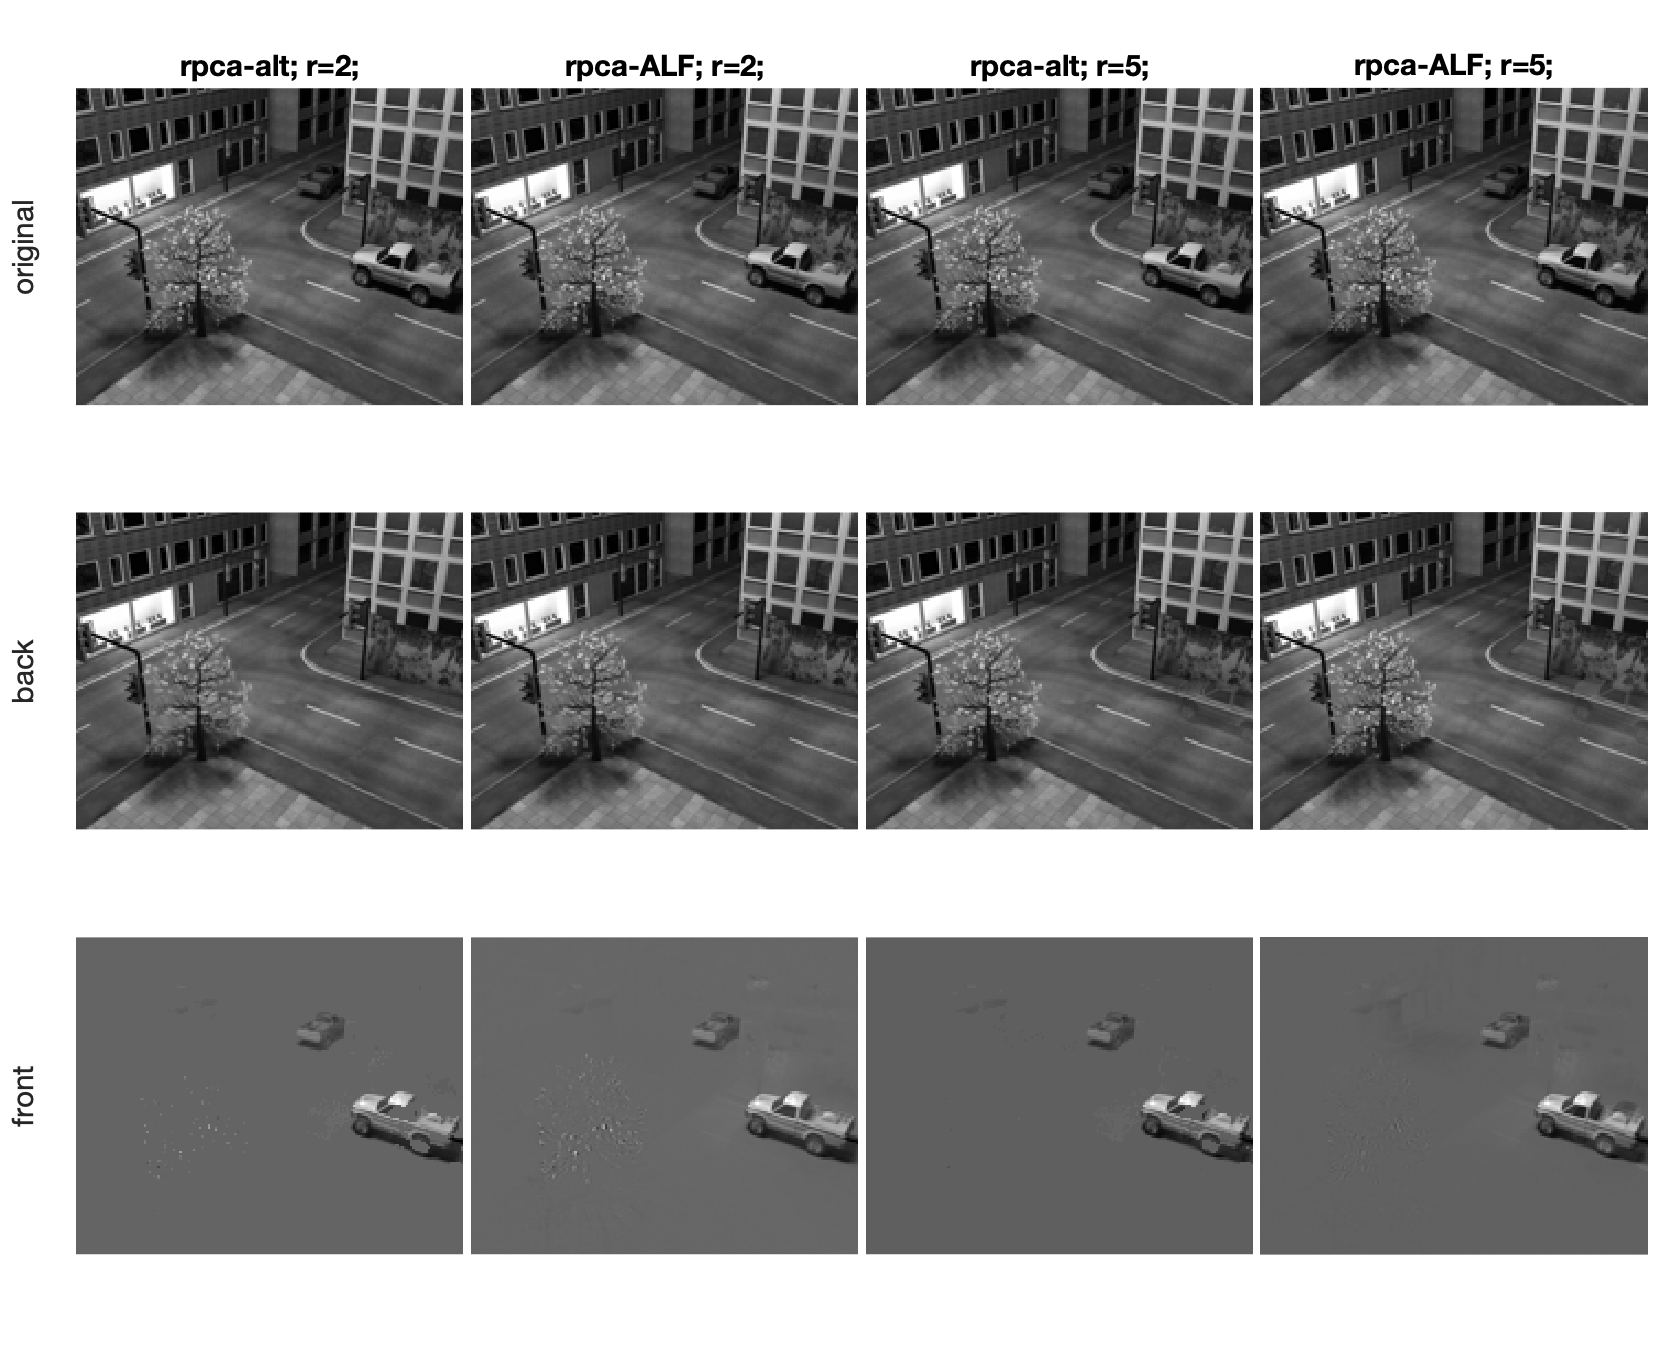

In [139]:
%plot inline

%parameters for figure and panel size

plotheight = image_height/4;
plotwidth = image_width/4;

subplotsx=4;
subplotsy=3; 

leftedge=2;
rightedge=0.4;   
topedge=1;
bottomedge=1.5;
spacex=0.2;
spacey=0.2;
fontsize=10;    
sub_pos=subplot_pos(plotwidth,plotheight,leftedge,rightedge,bottomedge,topedge,subplotsx,subplotsy,spacex,spacey);
 
%setting the Matlab figure
f=figure('visible','on');
clf(f);
set(gcf, 'PaperUnits', 'centimeters');
set(gcf, 'PaperSize', [plotwidth plotheight]);
set(gcf, 'PaperPositionMode', 'manual');
set(gcf, 'PaperPosition', [0 0 plotwidth plotheight]);

%loop to create axes
for i=1:subplotsx
for ii=1:subplotsy
 
ax=axes('position',sub_pos{i,ii},'XGrid','off','XMinorGrid','off','FontSize',fontsize,'Box','on','Layer','top');
 
%z=peaks;
%contour(z);


if ii==3 & (i==1 | i==2 | i==3| i==4)
    imshow (image_origial, []);
    if i == 1
        title('rpca-alt; r=2;', 'FontSize',22);
        ylabel('original', 'FontSize',22);
    end
    if i == 2
        title('rpca-ALF; r=2;', 'FontSize',22);
    end
    if i == 3
        title('rpca-alt; r=5;', 'FontSize',22);
    end
    if i == 4
        title('rpca-ALF; r=5;', 'FontSize',22);
    end
end

if ii==2
    
    if i == 1
        imshow(image_L_alt_2,[]);
        ylabel('back', 'FontSize',22);
    end
    if i == 2
        imshow(image_L_alf_laplace_2,[]);
    end
    if i == 3
        imshow(image_L_alt_5,[]);
    end
    if i == 4
        imshow(image_L_alf_laplace_5,[]);
    end
end    

if ii==1
    if i == 1
        imshow(image_S_alt_2,[]);
        ylabel('front', 'FontSize',22);
    end
    if i == 2
        imshow(image_S_alf_laplace_2,[]);
    end
    if i == 3
        imshow(image_S_alt_5,[]);
    end
    if i == 4
        imshow(image_S_alf_laplace_5,[]);
    end
    
end
 
if ii>1
    set(ax,'xticklabel',[]);
end
 
if i>1
    set(ax,'yticklabel',[]);
end
 

end
end
%Saving eps with matlab and then producing pdf and png with system commands
filename=['test'];
print(gcf, '-depsc2','-loose',[filename,'.eps']);
system(['epstopdf ',filename,'.eps'])
system(['convert -density 300 ',filename,'.eps ',filename,'.png'])

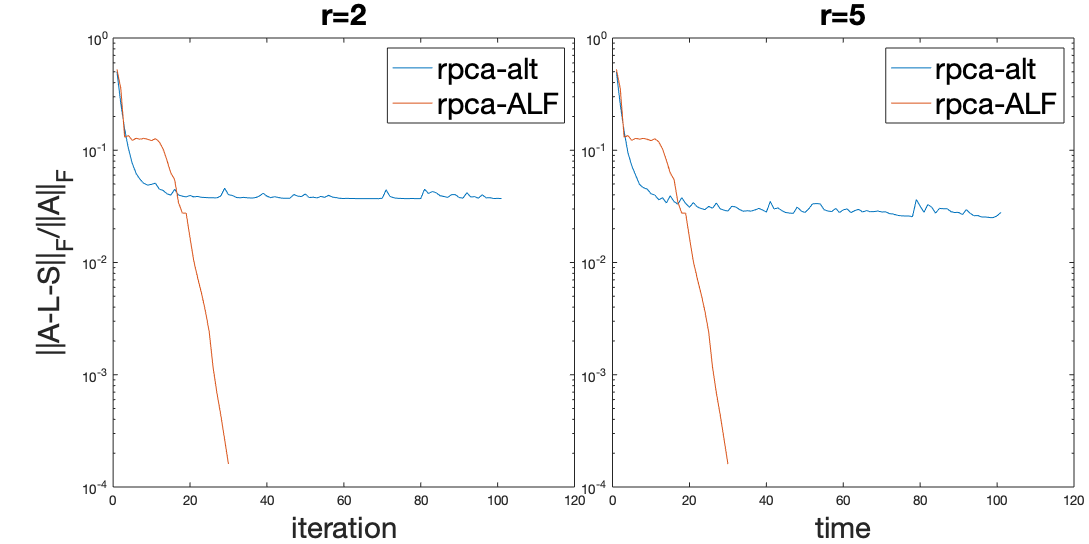

In [137]:
%plot inline

%parameters for figure and panel size

plotheight = image_height/10;
plotwidth = image_height/10 *2;

subplotsx=2;
subplotsy=1; 

leftedge=3;
rightedge=0.4;   
topedge=1;
bottomedge=1.5;
spacex=1;
spacey=1;
fontsize=10;    
sub_pos=subplot_pos(plotwidth,plotheight,leftedge,rightedge,bottomedge,topedge,subplotsx,subplotsy,spacex,spacey);
 
%setting the Matlab figure
f=figure('visible','on');
clf(f);
set(gcf, 'PaperUnits', 'centimeters');
set(gcf, 'PaperSize', [plotwidth plotheight]);
set(gcf, 'PaperPositionMode', 'manual');
set(gcf, 'PaperPosition', [0 0 plotwidth plotheight]);

%loop to create axes
for i=1:subplotsx
for ii=1:subplotsy
 
ax=axes('position',sub_pos{i,ii},'XGrid','off','XMinorGrid','off','FontSize',fontsize,'Box','on','Layer','top');
 
%z=peaks;
%contour(z);


if ii==1
    if i == 1
        x_alt_2 = 1:1:it_size_alt_2;
        y_alt_2 = Rel_error_alt_2;
        plot (x_alt_2, y_alt_2);
        hold on
        x_alf_2 = 1:1:it_size_alf_2;
        y_alf_2 = Rel_laplace_error_alf_2;
        plot (x_alf_2, y_alf_2);
        legend({'rpca-alt','rpca-ALF'}, 'FontSize',22);
        hold off
        xlabel('iteration', 'FontSize',22);
        title('r=2', 'FontSize',22);
        ylabel('||A-L-S||_F/||A||_F', 'FontSize',22);
    end
    if i == 2
        x_alt_5 = 1:1:it_size_alt_5;
        y_alt_5 = Rel_error_alt_5;
        plot (x_alt_5, y_alt_5);
        hold on

        x_alf_5 = 1:1:it_size_alf_5;
        y_alf_5 = Rel_laplace_error_alf_5;
        plot (x_alf_2, y_alf_2);
        legend({'rpca-alt','rpca-ALF'}, 'FontSize',22);
        hold off
        xlabel('time', 'FontSize',22);
        title('r=5', 'FontSize',22);
    end
end
 
 
if ii == 1
    set(gca, 'YScale', 'log');
end
 


end
end